Importation des library

In [1]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
plt.style.use('dark_background')

Chargement des données

In [ ]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
#day
time = "1m"
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2024-09-01', 
    interval=time
)

0it [00:00, ?it/s]

Mise en forme des données

In [ ]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.index = df_raw.index.tz_convert('Europe/Paris')
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-08 21:00:00+01:00,3128.31,3118.65,3135.62,3118.64,3934.7783
2025-12-08 21:15:00+01:00,3126.92,3128.30,3135.20,3125.18,1611.8975
2025-12-08 21:30:00+01:00,3128.78,3126.93,3130.43,3121.36,1663.4270
2025-12-08 21:45:00+01:00,3135.91,3128.79,3145.47,3125.35,7502.9793
2025-12-08 22:00:00+01:00,3130.76,3135.90,3135.90,3128.75,797.4804


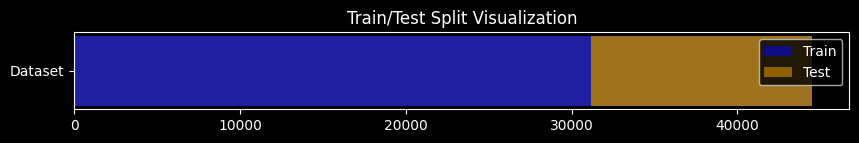

In [ ]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [5]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()

In [ ]:
import numpy as np
import pandas as pd
import vectorbt as vbt
from numba import jit
import warnings
warnings.filterwarnings('ignore')

# Fonction optimisée avec numba pour les calculs
@jit(nopython=True)
def calculate_signals_fast(close, open_, high, low, body_threshold):
    n = len(close)
    long_signal = np.zeros(n, dtype=np.bool_)
    short_signal = np.zeros(n, dtype=np.bool_)
    
    last_imbalance_high = np.nan
    last_imbalance_low = np.nan
    imbalance_up_prev = False
    
    for i in range(1, n):
        body_pct = abs(close[i] - open_[i]) / open_[i]
        
        # Imbalance actuel
        imbalance_up = body_pct > body_threshold and close[i] > open_[i]
        imbalance_down = body_pct > body_threshold and close[i] < open_[i]
        
        # Mettre à jour les derniers imbalances
        if imbalance_up:
            last_imbalance_high = high[i]
        if imbalance_down:
            last_imbalance_low = low[i]
        
        # Expiration après 10 bougies
        if i > 10:
            if not np.isnan(last_imbalance_high) and i - np.where(~np.isnan(last_imbalance_high))[0][-1] > 10:
                last_imbalance_high = np.nan
            if not np.isnan(last_imbalance_low) and i - np.where(~np.isnan(last_imbalance_low))[0][-1] > 10:
                last_imbalance_low = np.nan
        
        # Signaux
        if not np.isnan(last_imbalance_high) and low[i] <= last_imbalance_high and imbalance_up_prev:
            long_signal[i] = True
        
        if not np.isnan(last_imbalance_low) and high[i] >= last_imbalance_low:
            short_signal[i] = True
        
        imbalance_up_prev = imbalance_up
    
    return long_signal, short_signal

# Backtest principal pour 1min
def backtest_1minute(df, threshold_range=(0.00002, 0.0005), n_thresholds=30):
    """Backtest optimisé pour timeframe 1minute"""
    
    results = []
    thresholds = np.linspace(threshold_range[0], threshold_range[1], n_thresholds)
    
    for i, body_threshold in enumerate(thresholds):
        print(f"Test {i+1}/{n_thresholds}: threshold={body_threshold:.6f}")
        
        # Calcul des signaux optimisés
        long_signal, short_signal = calculate_signals_fast(
            df['Close'].values,
            df['Open'].values,
            df['High'].values,
            df['Low'].values,
            body_threshold
        )
        
        # Convertir en Series pandas
        long_signal_series = pd.Series(long_signal, index=df.index)
        short_signal_series = pd.Series(short_signal, index=df.index)
        
        # Filtrer les signaux trop rapprochés (cooldown 3 bougies)
        for j in range(3, len(long_signal_series)):
            if long_signal_series.iloc[j] and long_signal_series.iloc[j-3:j].any():
                long_signal_series.iloc[j] = False
            if short_signal_series.iloc[j] and short_signal_series.iloc[j-3:j].any():
                short_signal_series.iloc[j] = False
        
        # Backtest
        portfolio = vbt.Portfolio.from_signals(
            close=df['Close'],
            entries=long_signal_series,
            exits=short_signal_series,
            init_cash=10000,
            fees=0.001,
            slippage=0.002,  # Slippage plus élevé en 1min
            size=0.03,  # Position size réduit
            freq='1m',
            stop_loss=0.008,  # Stop loss 0.8%
            take_profit=0.015,  # Take profit 1.5%
        )
        
        stats = portfolio.stats()
        stats['body_threshold'] = body_threshold
        
        # Métriques spécifiques 1min
        trades = portfolio.trades.records_readable
        if len(trades) > 0:
            durations = trades['Duration'].dt.total_seconds() / 60
            stats['avg_duration_min'] = durations.mean()
            stats['median_duration_min'] = durations.median()
            stats['win_rate'] = (trades['PnL'] > 0).mean() * 100
        else:
            stats['avg_duration_min'] = 0
            stats['median_duration_min'] = 0
            stats['win_rate'] = 0
        
        results.append(stats)
    
    return pd.DataFrame(results)

# Exécution
results = backtest_1minute(df, threshold_range=(0.00002, 0.0003), n_thresholds=40)
results.to_csv('1min_optimized.csv', index=False)

# Analyse
print("\n=== TOP 5 PARAMÈTRES 1MIN ===")
top_5 = results.nlargest(5, 'Total Return [%]')
print(top_5[['body_threshold', 'Total Return [%]', 'Sharpe Ratio', 
             'Max Drawdown [%]', 'win_rate', 'Total Trades', 'avg_duration_min']])

Backtest completed for body_threshold: 0.0001
Backtest completed for body_threshold: 0.0002
Backtest completed for body_threshold: 0.00030000000000000003
Backtest completed for body_threshold: 0.0004
Backtest completed for body_threshold: 0.0005
Backtest completed for body_threshold: 0.0006000000000000001
Backtest completed for body_threshold: 0.0007000000000000001
Backtest completed for body_threshold: 0.0008
Backtest completed for body_threshold: 0.0009000000000000001
Backtest completed for body_threshold: 0.001
Backtest completed for body_threshold: 0.0011
Backtest completed for body_threshold: 0.0012000000000000001
Backtest completed for body_threshold: 0.0013000000000000002
Backtest completed for body_threshold: 0.0014000000000000002
Backtest completed for body_threshold: 0.0015
Backtest completed for body_threshold: 0.0016
Backtest completed for body_threshold: 0.0017000000000000001
Backtest completed for body_threshold: 0.0018000000000000002
Backtest completed for body_threshold